<a href="https://colab.research.google.com/github/bstrain71/422_bank_marketing/blob/master/Strain_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ingest

In [59]:
# Scikit Learn documentation for this assignment:
# http://scikit-learn.org/stable/auto_examples/classification/
#   plot_classifier_comparison.html
# http://scikit-learn.org/stable/modules/generated/
#   sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.score
# http://scikit-learn.org/stable/modules/generated/
#   sklearn.linear_model.LogisticRegression.html
# http://scikit-learn.org/stable/modules/model_evaluation.html 
# http://scikit-learn.org/stable/modules/generated/
#  sklearn.model_selection.KFold.html

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 24601

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection

# initial work with the smaller data set
bank = pd.read_csv('https://raw.githubusercontent.com/bstrain71/422_bank_marketing/master/bank.csv', sep = ';')  # start with smaller data set
# examine the shape of original input data
print(bank.shape)


(4521, 17)


In [60]:

# drop observations with missing data, if any
bank.dropna()
# examine the shape of input data after dropping missing data
# no na wow a miracle
print(bank.shape)


(4521, 17)


## EDA


In [61]:

# look at the list of column names, note that y is the response
list(bank.columns.values)


['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

In [62]:

# look at the beginning of the DataFrame
bank.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [63]:
bank.response.value_counts() # there are 521 yes and 4000 no

no     4000
yes     521
Name: response, dtype: int64

In [64]:

# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)

# define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

# define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

# define response variable to use in the model
response = bank['response'].map(convert_to_binary)

# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data = np.array([np.array(default), np.array(housing), np.array(loan), 
    np.array(response)]).T

# examine the shape of model_data, which we will use in subsequent modeling
print(model_data.shape)
print(model_data[1:10,])

# the rest of the program should set up the modeling methods
# and evaluation within a cross-validation design

# the response variable is in the last column, 3

(4521, 4)
[[0 1 1 0]
 [0 1 0 0]
 [0 1 1 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 1 0]]


In [65]:
sum(model_data[:,3])

521

In [66]:
# response vs default: only 9 intersections
pd.crosstab(model_data[:,3], model_data[:,0])



col_0,0,1
row_0,,
0,3933,67
1,512,9


In [67]:
# response vs housing: 220 intersections
pd.crosstab(model_data[:,3], model_data[:,1])


col_0,0,1
row_0,,
0,1661,2339
1,301,220


In [68]:
# response vs loan: 43 intersections
pd.crosstab(model_data[:,3], model_data[:,2])


col_0,0,1
row_0,,
0,3352,648
1,478,43


## Modelling

If a simple logistic regression model with L2 regularization is run on the data the model predicts that no one will respond "yes" to the question of whether or not they have subscribed to a term deposit.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#X_train, X_test, y_train, y_test = train_test_split(
#model_data[:,0:3], model_data[:,3],
#stratify = model_data[:,3], random_state=24601)

# split the model into yes and no so I can ensure that the "yes" responses
# are evenly distributed in the train / test set. train_test_split can't
# do this or I don't know how to make it do so

# separate the yes' and no's
yes = model_data[np.where(model_data[:,3] == 1)]
no = model_data[np.where(model_data[:,3] == 0)]

# randomly shuffle them
np.random.seed(24601)
np.random.shuffle(yes)
np.random.shuffle(no)

# 80% of 4000 no's is 3200 and 80% of 521 yes is 416.8 approx 417
training_set = np.concatenate((no[:3199,:], yes[:416,:]), axis=0)
test_set = np.concatenate((no[3199:,:], yes[416:,:]), axis=0)

# split it up into variables that are nice to feed into the models
X_train = training_set[:,0:3]
X_test = test_set[:,0:3]
y_train = training_set[:,3]
y_test = test_set[:,3]

In [126]:
logreg = LogisticRegression(solver = 'lbfgs').fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

# this predicts too many zeroes - trivial solution
#logreg_predictions = pd.DataFrame(logreg.predict(X_test))
#logreg_predictions.describe()

logreg_predictions = logreg.predict_proba(X_test)

# the probability of being y=1

prob1 = logreg.predict_proba(X_test)[:,1]
# If we use 0.25 as the cutoff value, then we predict like below

# note: there are 416 'yes' in the test set
co05 = [1 if i > 0.05 else 0 for i in prob1]
co10 = [1 if i > 0.10 else 0 for i in prob1]
co15 = [1 if i > 0.15 else 0 for i in prob1]
co16 = [1 if i > 0.16 else 0 for i in prob1] # largest nontrivial cutoff
co17 = [1 if i > 0.17 else 0 for i in prob1]

# try some smaller increments
co07 = [1 if i > 0.0912 else 0 for i in prob1]

print(pd.DataFrame(co07).describe())
sum(co07)


Training set score: 0.885
Test set score: 0.884
                0
count  906.000000
mean     0.839956
std      0.366850
min      0.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      1.000000


761

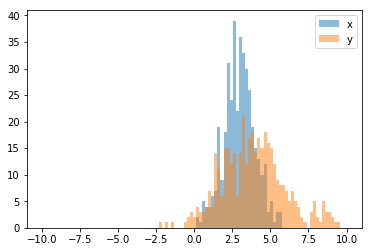

In [71]:
import random
import numpy
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()


Neither model is detecting any positives. In light of this both models need the sensitivity increased. Targeted marketing can tolerate, and should expect, some false positives when doing business.

In [72]:

from sklearn.naive_bayes import BernoulliNB


bayes = BernoulliNB().fit(X_train, y_train)
print("Training set score: {:.3f}".format(bayes.score(X_train, y_train)))
print("Test set score: {:.3f}".format(bayes.score(X_test, y_test)))

bayes_predictions = pd.DataFrame(bayes.predict(X_test))

bayes_predictions.describe()

Training set score: 0.885
Test set score: 0.884


,0
count,906.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


Let's try reducing the cutoff from 0.5 to something smaller - although I don't foresee getting > 88% accuracy in that way but who knows.

Both the logistic regression model (with L2 regularization) and the Naïve Bayes model are unable to predict anything but the trivial solution without additional variables. I recommend that management pull their heads out of their ass and model a sparse dataset using more than just three binary predictor variables.

In [0]:
# let's do the eda again with the full dataset and pair down the variables like
# sane human beings who give a shit about the result

bank = pd.read_csv('https://raw.githubusercontent.com/bstrain71/422_bank_marketing/master/bank.csv', sep = ';')  # start with smaller data set


# make yes/no variables binary
# define binary variable for having credit in default
bank['default'] = bank['default'].map(convert_to_binary)

# define binary variable for having a mortgage or housing loan
bank['housing'] = bank['housing'].map(convert_to_binary)

# define binary variable for having a personal loan
bank['loan'] = bank['loan'].map(convert_to_binary)

# define response variable to use in the model
bank['response'] = bank['response'].map(convert_to_binary)


# dummy variables for job
bank = pd.concat([bank,  pd.get_dummies(bank['job'],drop_first= True)],
                 axis = 1)

# dummy variables for marital status
bank = pd.concat([bank,  pd.get_dummies(bank['marital'],drop_first= True)],
                 axis = 1)

# dummy variables for education
bank = pd.concat([bank,  pd.get_dummies(bank['education'],drop_first= True)],
                 axis = 1)


# drop the columns i don't want
model_data = bank.drop(['job','marital','education','contact',
                        'day','month','poutcome'],
                       axis = 1)

In [74]:
model_data.head()

,age,default,balance,housing,loan,duration,campaign,pdays,previous,response,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown,married,single,secondary,tertiary,unknown
0,30,0,1787,0,0,79,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,33,0,4789,1,1,220,1,339,4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
2,35,0,1350,1,0,185,1,330,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
3,30,0,1476,1,1,199,4,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,59,0,0,1,0,226,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


## Results